In [ ]:
### do a pre-treatment of traits overlapping in elements, to check if every traits is rightly attributed
# awk -F'\t' '{print $8}' OFS=$'\t' pos_gwas.tsv |cut -d_ -f1 >> a
# awk -F'\t' '{print $10}' OFS=$'\t' ee_gwas.tsv |cut -d_ -f1 >> a
# awk -F'\t' '{print $10}' OFS=$'\t' neg_gwas.tsv |cut -d_ -f1 >> a |sort -u > rsId_overlapping
# grep -wFf rsId_overlapping dic_rsId_traits.tsv |awk -F'\t' '{if ($3!="") print $1,$2,$3,$4,$5,$5}' OFS=$'\t' > traits_overlapping.tsv #manually curate that file
# rm rsId_overlapping

In [28]:
### Compute data
dic_rs_trait = {}
dic_rs_type = {}
with open("/home/mouren/Data/variants/gwas/ld_pipe/traits_overlapping.tsv") as file:
    for line in file: 
        if line.strip().split("\t")[0] not in dic_rs_trait:
            dic_rs_trait[line.strip().split("\t")[0]] = [line.strip().split("\t")[5]]
        else:
            if line.strip().split("\t")[5] not in dic_rs_trait[line.strip().split("\t")[0]]:
                dic_rs_trait[line.strip().split("\t")[0]].append(line.strip().split("\t")[5])
with open("/home/mouren/Data/variants/gwas/ld_pipe/dic_rsId_traits.tsv") as file:
    for line in file: 
        if line.strip().split("\t")[1] == "missense_variant":
            dic_rs_type[line.strip().split("\t")[0]] = "Missense"
        elif line.strip().split("\t")[1] == "synonymous_variant":
            dic_rs_type[line.strip().split("\t")[0]] = "Synonymous"
        else:
            dic_rs_type[line.strip().split("\t")[0]] = "Other"

data = {"Disease":[0,0,0],"Biological process":[0,0,0],"Measurement":[0,0,0],"Phenotype":[0,0,0],"Other":[0,0,0],"Total":[0,0,0]} #ee, ctrl-, ctrl+
data_syn = {"Disease":[0,0,0],"Biological process":[0,0,0],"Measurement":[0,0,0],"Phenotype":[0,0,0],"Other":[0,0,0],"Total":[0,0,0]} #ee, ctrl-, ctrl+

with open("/home/mouren/Data/variants/gwas/ld_pipe/ee_gwas.tsv") as file:
    for line in file: 
        rs_lead = line.strip().split()[9].split("_")[0]
        if rs_lead in dic_rs_trait:
            for trait in dic_rs_trait[rs_lead]:
                data[trait][1] += 1
                if dic_rs_type[rs_lead] == "Synonymous":
                    data_syn[trait][1] += 1
        else:
            data["Other"][1] += 1
            if dic_rs_type[rs_lead] == "Synonymous":
                data_syn["Other"][1] += 1
        
        data["Total"][1] += 1
        if dic_rs_type[rs_lead] == "Synonymous":
            data_syn["Total"][1] += 1

with open("/home/mouren/Data/variants/gwas/ld_pipe/neg_gwas.tsv") as file:
    for line in file: 
        rs_lead = line.strip().split()[9].split("_")[0]
        if rs_lead in dic_rs_trait:
            for trait in dic_rs_trait[rs_lead]:
                data[trait][0] += 1
                if dic_rs_type[rs_lead] == "Synonymous":
                    data_syn[trait][0] += 1
        else:
            data["Other"][0] += 1
            if dic_rs_type[rs_lead] == "Synonymous":
                data_syn["Other"][0] += 1
        
        data["Total"][0] += 1
        if dic_rs_type[rs_lead] == "Synonymous":
            data_syn["Total"][0] += 1

with open("/home/mouren/Data/variants/gwas/ld_pipe/pos_gwas.tsv") as file:
    for line in file: 
        rs_lead = line.strip().split()[7].split("_")[0]
        if rs_lead in dic_rs_trait:
            for trait in dic_rs_trait[rs_lead]:
                data[trait][2] += 1
                if dic_rs_type[rs_lead] == "Synonymous":
                    data_syn[trait][2] += 1
        else:
            data["Other"][2] += 1
            if dic_rs_type[rs_lead] == "Synonymous":
                data_syn["Other"][2] += 1
        
        data["Total"][2] += 1
        if dic_rs_type[rs_lead] == "Synonymous":
            data_syn["Total"][2] += 1

### Normalize value by nb total of element in each dataset 
data_norm = {}
data_syn_norm = {}

for key,val in data.items():
    neg = val[0]/13253
    ee = val[1]/13481
    pos = val[2]/404325
    data_norm[key] = [neg,ee,pos]

for key,val in data_syn.items():
    neg = val[0]/13253
    ee = val[1]/13481
    pos = val[2]/404325
    data_syn_norm[key] = [neg,ee,pos]

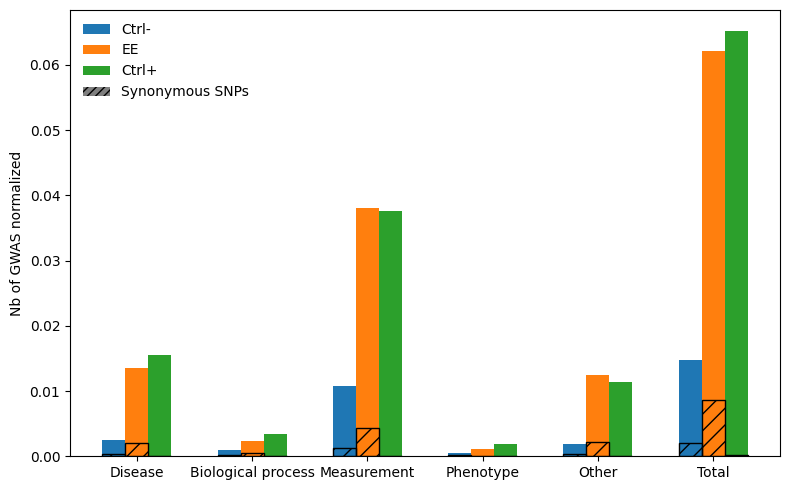

In [ ]:
### PLOT
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

# Get the categories (keys) and prepare for plotting
categories = list(data_norm.keys())
n_groups = len(categories)
n_sub_bars = 3  # we have 3 values for each category
bar_width = 0.2
x = np.arange(n_groups)  # the x locations for each group

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars from the first dictionary
for i in range(n_sub_bars):
    # Extract the i-th value from each category
    values1 = [data_norm[cat][i] for cat in categories]
    # Plot the bars
    ax.bar(
        x + i * bar_width, 
        values1, 
        width=bar_width, 
    )

# Overlay bars from the second dictionary with a hatch
for i in range(n_sub_bars):
    # Extract the i-th value from each category
    values2 = [data_syn_norm[cat][i] for cat in categories]
    # Plot the overlaid bars (same positions), with a hatch
    ax.bar(
        x + i * bar_width, 
        values2, 
        width=bar_width, 
        fill=False, 
        hatch='//',         # hatch pattern
        edgecolor='black',  # so the hatch is visible
    )

# Aesthetics
ax.set_xticks(x + bar_width * (n_sub_bars - 1) / 2)
ax.set_xticklabels(categories)
ax.set_ylabel('Nb of GWAS normalized')

from matplotlib.patches import Patch
from matplotlib import font_manager
import matplotlib.patches as mpatches

c1 = Patch(facecolor=sns.color_palette()[0], label="Ctrl-")
c2 = Patch(facecolor=sns.color_palette()[1], label="EE")
c3 = Patch(facecolor=sns.color_palette()[2], label="Ctrl+")
circ1 = mpatches.Patch(facecolor=sns.color_palette()[7],alpha=1,hatch=r'////',label='Synonymous SNPs')

plt.legend(handles=[c1, c2, c3, circ1], loc='upper left', frameon=False)

plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/supplementary_figures/supp_fig7/gwas_catalog.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/supplementary_figures/supp_fig7/gwas_catalog.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
